# Bass Diffusion Model

## [notes based on Bass basement](http://bassbasement.org/BassModel/Default.aspx)

How do products/ideas come to be adopted in the marketplace? This is one of the fundamental questions in marketing, the answer to which unlocks the doors to market success. Being able to accurately forecast adoption is one of the holy grails for any innovative business.

Frank Bass, the father of modern quantitative marketing and a pioneer of operations management, proposed one of the most important operations/marketing models in [1963](http://www.bassbasement.org/F/N/FMB/Pubs/Bass%201963%20Dynamic%20Model.pdf) and demonstrated its usefulness in a [1969 paper](http://www.bassbasement.org/F/N/FMB/Pubs/Bass%201969%20New%20Prod%20Growth%20Model.pdf). What's come to be known as the Bass diffusion model still serves as the basis for modern market share predictive models. There have been many extensions/modifications of the original model to make the market share predictions more flexible and accurate, but they are all built upon the foundations laid by Frank Bass. The original Bass model is parameterized by 3 variables: coefficient of innovation, coefficient of immitation, and total market potential.

## Introducing the model

Bass and a economics PhD student at Purdue, Peter Frevert, wanted to translate the conceptual ideas regarding diffusion via word of mouth in Everett Rogers' book, *Diffusion of Innovations*, into something more mathematical. The key idea of innovators and immitators, according to Bass, boiled down to:

"The probability of adopting by those who have not yet adopted is a linear function of those who had previously adopted."

This can be roughly translated to math as:

$$
\frac{f(t)}{1-F(t)}\approx p+q\cdot A(t)
$$
where $p$ is the coefficient of innovation (since it does not interact with the cumulative adopter function $A(t)$) and $q$ is the coefficient of imitation (since it multiplies $A(t)$).

This is a differential equation, but it does not have a general closed-form solution. However, a slight algebraic manipulation, by cleverly choosing a constant M, can make this equation solvable (for $f(t)$).

$$
\frac{f(t)}{1-F(t)} = p+\frac{q}{M}[A(t)]
$$


![hammer time](./did-someone-say-break-it-down.jpg)
$$
\underbrace{\frac{\overbrace{f(t)}^{\text{proportion to adopt in }t}}{1-\underbrace{F(t)}_{\text{proportion of M who have adopted}}}}_{\text{Proportion of remaining market to adopt at }t} = \underbrace{\overbrace{p}^{\text{coeff. of innovation}}+\frac{\overbrace{q}^{\text{coeff. of imitation}}}{\underbrace{M}_{\text{Total market potential}}}[ \underbrace{A(t)}_{\text{previous adopters}}]}_{\text{linear function of previous adopters}}
$$

Mathematically, the different components are thus related:
$$
f(t)=\frac{dF(t)}{dt} \text{, i.e.  $f$ is the derivative of $F$} \\
A(t) = MF(t), \text{  for }t>0 \\
a(t)=\frac{dA(t)}{dt}
$$


With some algebra...
$$
\frac{f(t)}{1-F(t)} = p+\frac{q}{M}[A(t)] \implies\\
\underbrace{a(t)=Mp+[q-p]A(t)-\frac{q}{M}A(t)^2}_{\text{use this to run regression to estimate model}} \implies \\
f(t)=p+[q-p]F(t)-q[F(t)]^2 \\
\underbrace{\implies}_{\text{DiffEq...and, tada!}} \\
F(t)=\frac{1-e^{-(p+q)t}}{1+\frac{q}{p}e^{-(p+q)t}} \text{    and...} \\
f(t)=\frac{\frac{{p+q}^2}{p}e^{-(p+q)t}}{\big(1+\frac{q}{p}e^{-(p+q)t}\big)^2}
$$


### Estimating the Bass model with sales data and OLS

** This is not a very good method as it yields inconsistent estimators **

Given some sales data, we can estimate the parameters $(M,p,q)$ of the Bass model. We  begin with the linearized form of the model:


$$
\underbrace{a(t)}_{y}=\underbrace{Mp}_{\beta_0}+\underbrace{[q-p]}_{\beta_1}\underbrace{A(t)}_{x}\underbrace{-\frac{q}{M}}_{\beta_2}\underbrace{A(t)^2}_{x^2} \sim y=\beta_0+\beta_1x+\beta_2x^2 \implies \\
\beta_0=Mp\text{, }\beta_1=q-p\text{, }\beta_2=-\frac{q}{M}
$$

After estimating the regression equation, we will have 3 equations to solve for our 3 structural parameters ($M,p,q$), i.e. the structural parameters are "identifiable."

$$
\beta_0=Mp\text{, }\beta_1=q-p\text{, }\beta_2=-\frac{q}{M} \implies \\
p=\beta_0/M=q-\beta_1 \text{ and } q=-M\beta_2 \implies \\
\beta_0/M=-M\beta_2-\beta_1\\
0=-\beta_2M^2-\beta_1M-\beta_0\\
0=\beta_2M^2+\beta_1M+\beta_0 \implies\\
M = \frac{-\beta_1\pm\sqrt{\beta_1^2-4\beta_2\beta_0}}{2\beta_2}\implies\\
q = -M\beta_2 \text{ and } p=\beta_0/M
$$

## Estimating Bass model with sales data using [non-linear least squares](https://en.wikipedia.org/wiki/Non-linear_least_squares)

** This is the preferred method **

We use an optimization program to find $M$, $p$, and  $q$ that minimizes the sum of squared errors of the Bass model vs actual data.

$$
\DeclareMathOperator*{\argmin}{arg\,min}
\{\hat{M},\hat{p},\hat{q}\}=\argmin_{M,p,q}\bigg\{\sum_{t=1}^{T}{\bigg(M\frac{\frac{(p+q)^2}{p}e^{-(p+q)t}}{\big(1+\frac{q}{p}e^{-(p+q)t}\big)^2}-S_t\bigg)^2}\bigg\}
$$

In [436]:
data = pd.read_excel('./smartphone.xlsx')
data['t'] = range(1, len(data)+1)
import datetime
data['dates'] = pd.to_datetime(data.year.apply(lambda x: datetime.date(x,1,1)))
data.Adoption = data.Adoption*325e6*.8 # change adoption from % to total users
data.New_Adoption = data.New_Adoption*325e6*.8
data['AdoptionSq'] = data.Adoption.apply(lambda x: x**2)
# run OLS
res = smf.ols(formula = 'New_Adoption~Adoption+AdoptionSq', data=data).fit()
b0,b1,b2 = res.params
def solve_bass_ols(b0,b1,b2):
    m = (-b1-np.sqrt(b1**2-4*b2*b0))/(2*b2)
    q = -m*b2
#     q = (b1+np.sqrt(b1**2-4*b2*b0))/(2) # alternative formulation
    p = b0/m
#     p = (-b1+np.sqrt(b1**2-4*b2*b0))/(2) # alternative formulation
    return m,p,q
m,p,q = solve_bass_ols(b0,b1,b2)
print('m = {}, p={}, q={}'.format(m,p,q))

m = 230974385.254, p=5.30405295377e-17, q=0.587704611086


In [437]:
paramguess = [m,p,q]
def residual(params, t, new):
    M = params[0]
    P = params[1]
    Q = params[2]
    Bass = M * (((P+Q)**2/P)*np.exp(-(P+Q)*t))/(1+(Q/P)*np.exp(-(P+Q)*t))**2 
    return (Bass - new)
paramfinal,success = leastsq(residual, params, args=(data.t, data.New_Adoption))
print(success)
m,p,q = paramfinal
print('m = {}, p={}, q={}'.format(m,p,q))

1
m = 217218082.418, p=0.0044079817091, q=0.649899218129


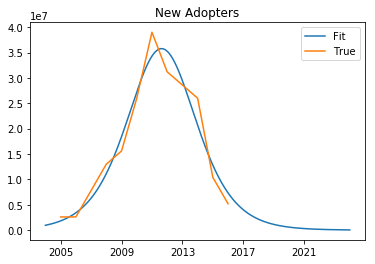

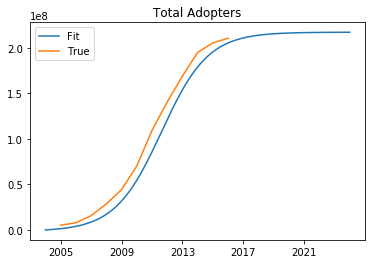

In [438]:
dts = pd.date_range('1/1/2004', end = '1/1/2024')
tp=(np.linspace(0, 20, num=(len(dts))))
cofactor= np.exp(-(p+q) * tp)
sales_pdf= m* (((p+q)**2/p)*cofactor)/((1+(q/p)*cofactor)**2)
plt.plot(dts, sales_pdf,data.dates,data.New_Adoption)
plt.title('New Adopters')
plt.legend(['Fit', 'True'])
plt.show()

# Cumulative sales (cdf)
sales_cdf= m*(1-cofactor)/(1+(q/p)*cofactor)
plt.plot(dts, sales_cdf,data.dates,data.Adoption)
plt.title('Total Adopters')
plt.legend(['Fit', 'True'])
plt.show()

# Recall principles of marketing and S curves

Text(0.5,1,u'New Smart Phone Adopters')

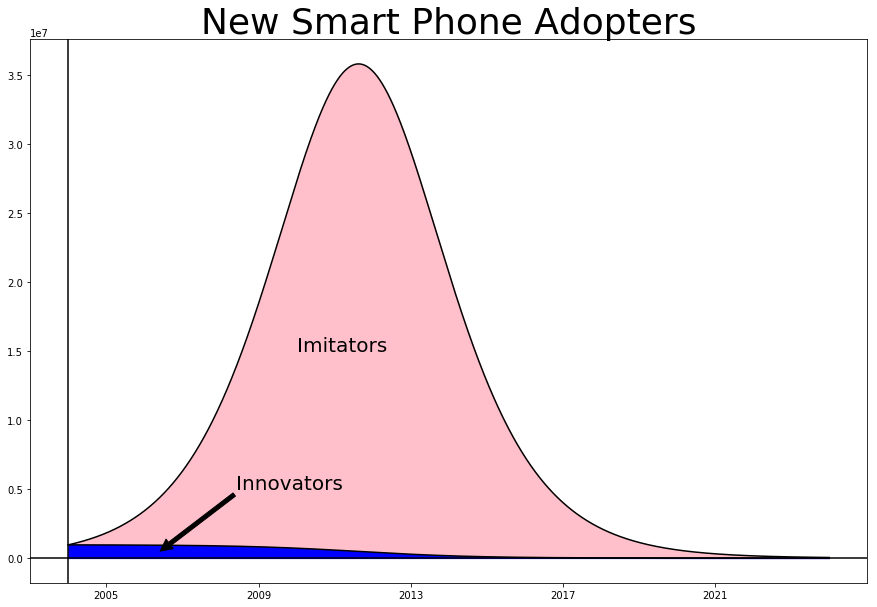

In [439]:
remaining_mkt = m-sales_cdf
innovators = np.concatenate([np.array([m]), remaining_mkt[:-1]])*p
totalinnovators = np.cumsum(innovators)
plt.figure(figsize =(15,10))
plt.plot(dts, sales_pdf,dts, innovators,c = 'black')
plt.axhline(y = 0, c = 'black')
plt.axvline(x = pd.to_datetime('1/1/2004'), c = 'black')
plt.fill_between(dts, sales_pdf, innovators, color= 'pink')
plt.fill_between(dts, innovators, 0, color = 'blue')
plt.annotate('Imitators', xy=(pd.to_datetime('1/1/2010'), 1.5e7), xytext=(pd.to_datetime('1/1/2010'), 1.5e7), fontsize = 20)
plt.annotate('Innovators', xy=(pd.to_datetime('6/1/2006'), 5e5), xytext=(pd.to_datetime('6/1/2008'), 5e6), fontsize = 20,arrowprops=dict(facecolor='black', shrink=0.0001))
plt.title('New Smart Phone Adopters', fontsize = 36)